In [1]:
scores = '../out/ko_scores.txt'
dev = '../out/deviating.tsv'
sgd = '../out/SGD_features.tab'

In [2]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt
from adjustText import adjust_text
from matplotlib_venn import venn2, venn3

sns.set_style('white')

plt.rc('font', size=12)

In [3]:
import random
import itertools
import numpy as np
import pandas as pd

In [4]:
g = pd.read_table(sgd, sep='\t', header=None)
gn = g[g[1] == 'ORF'].set_index(3)[4].dropna().to_dict()
gd = g[g[1] == 'ORF'].set_index(3)[15].dropna().to_dict()

In [5]:
m = pd.read_table(scores, index_col=[0, 2, 1])
m['phenotype'] = m['qvalue'] < 0.05
genes = None
for s in {x[0] for x in m.index}:
    gs = {x[0] for x in m.loc[s].index}
    if genes is None:
        genes = gs
    else:
        genes = genes.intersection(gs)
    print(s, len(gs))
print('')
print('total', len(genes))
genes = sorted(genes)
# p = m.reset_index().set_index('gene').loc[genes].groupby('condition').sum()['phenotype']
# pgenes = m.loc[(slice(None), genes),].groupby('gene')['phenotype'].max()
# pgenes = set(pgenes[pgenes == True].index)

Y55 4190
S288C 4889
UWOP 4014
YPS 4093

total 3786


In [6]:
strains = ['S288C', 'Y55',
           'UWOP', 'YPS']
cstrains = {x: c
            for x, c in zip(strains, sns.color_palette('Set1', len(strains)))}

In [7]:
d = pd.read_table(dev, index_col=[4, 5, 1, 0])
d = d.loc[(slice(None), slice(None), genes),]
d = d.sort_index().reset_index()

In [8]:
d.head()

,strain1,strain2,gene,condition,scores1,scores2,sum,sub,phenotype1,phenotype2,scores-qvalue1,scores-qvalue2,var,mean,pval,qval,qvalue
0,S288C,UWOP,YAL002W,"2,4-Dichlorophenoxyacetic acid (48H)",-6.027977,-1.613602,-7.641579,4.414374,True,False,1.605208e-11,0.442146,1.262408,2.186347,0.038790,0.874195,0.874195
1,S288C,UWOP,YAL002W,39ºC (48H),-1.966362,-0.560451,-2.526813,1.405911,False,False,2.816448e-01,0.994997,1.102933,1.370533,0.487206,0.874195,0.874195
2,S288C,UWOP,YAL002W,39ºC (72H),-1.437009,-0.966565,-2.403574,0.470444,False,False,6.575925e-01,0.913763,1.068361,1.293479,0.779460,0.874195,0.874195
3,S288C,UWOP,YAL002W,5-FU (48H),-1.945708,-0.313872,-2.259580,1.631836,False,False,3.097005e-01,1.000000,1.026107,1.202748,0.337911,0.874195,0.874195
4,S288C,UWOP,YAL002W,6-AU (48H),1.345415,2.018603,-3.364018,0.673188,False,False,6.606129e-01,0.253184,1.241682,1.900388,0.838506,0.874195,0.874195


In [9]:
def do_analysis(d, strains,
                qvalue = 0.01,
                scores_qvalue = 0.05):
    res = []
    ds = {}
    for s in strains:
        x1 = d[d['strain1'] == s]
        x2 = d[d['strain2'] == s]
        x1 = x1.rename(columns={'strain1': 'strain',
                                'phenotype1': 'phenotype',
                                'scores-qvalue1': 'scores-qvalue',
                                'strain2': 'other',
                                'phenotype2': 'otherp'}
                      ).T.sort_index().T
        x2 = x2.rename(columns={'strain2': 'strain',
                                'phenotype2': 'phenotype',
                                'scores-qvalue2': 'scores-qvalue',
                                'strain1': 'other',
                                'phenotype1': 'otherp'}
                      ).T.sort_index().T
        x = pd.concat([x1, x2]).reindex()

        y = x[(x['phenotype']) | (x['otherp'])]

        for o in set(strains).difference([s]):
            e = y[
                  (y['scores-qvalue'] <= scores_qvalue) &
#                   (y['phenotype']) &
                  (y['qvalue'] < qvalue) &
                  (y['other'] == o)].set_index(['gene',
                                                'condition'])
            sh = y[
                   (y['scores-qvalue'] <= scores_qvalue) &
#                    (y['phenotype']) &
                   (y['otherp']) &
                   (y['qvalue'] >= qvalue) &
                   (y['other'] == o)].set_index(['gene',
                                                 'condition'])

            p = sh.shape[0] + e.shape[0]

            res.append((s, o,
                        2,
                        sh.shape[0]/p,
                        e.shape[0]/p,
                        sh.shape[0],
                        e.shape[0]))

        for i in [2, 3]:
            for o in itertools.combinations(set(strains).difference([s]),
                                            i):
                e = y[
                      (y['scores-qvalue'] <= scores_qvalue) &
#                       (y['phenotype']) &
                      (y['qvalue'] < qvalue) &
                      (y['other'].isin(o))].set_index(['gene',
                                                       'condition']).sort_index()
                sh = y[
                       (y['scores-qvalue'] <= scores_qvalue) &
#                        (y['phenotype']) &
                       (y['otherp']) &
                       (y['qvalue'] >= qvalue) &
                       (y['other'].isin(o))].groupby(['gene',
                                                      'condition'])['strain'].count()
                sh = sh[sh >= i]

                e = e.loc[e.index.difference(sh.index)]

                p = sh.shape[0] + e.shape[0]

                if i == 3:
                    ds[s] = sh.index

                res.append((s, ','.join(o),
                            i+1,
                            sh.shape[0]/p,
                            e.shape[0]/p,
                            sh.shape[0],
                            e.shape[0]))

    r = pd.DataFrame(res,
                     columns=['strain',
                              'others',
                              'comparisons',
                              'shared',
                              'exclusive',
                              'nshared',
                              'nexclusive'])

    p = r.set_index(['strain',
                     'others',
                     'comparisons']).stack()

    p = p.to_frame().reset_index()
    p.columns = ['strain',
                 'others',
                 'comparisons',
                 'variable',
                 'value']
    
    return p, ds

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:21: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/mgalactus/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


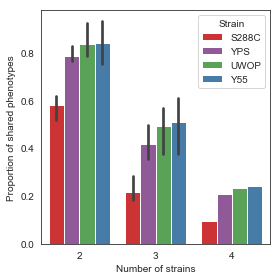

In [10]:
p, ds = do_analysis(d, strains)

sns.catplot(x='comparisons', y='value',
            hue='strain',
            height=4, aspect=1,
            kind='bar', data=p[p['variable'] == 'shared'],
            hue_order=p[(p['variable'] == 'shared') &
                        (p['comparisons'] == 2)
                       ].groupby('strain')['value'].mean().sort_values().index,
            palette=[cstrains[x] for x in p[(p['variable'] == 'shared') &
                                            (p['comparisons'] == 2)
                                           ].groupby('strain')['value'
                                           ].mean().sort_values().index],
            legend=False)

plt.legend(title='Strain',
           loc='upper right')

plt.ylabel('Proportion of shared phenotypes')
plt.xlabel('Number of strains')

sns.despine(top=False,
            right=False)

plt.savefig('deviations-sets-increasing.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('deviations-sets-increasing.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [11]:
pp = None
for i, j in zip([1E-10, 1E-8, 1E-6, 1E-4, 1E-2, 0.05],
                [1E-8, 1E-6, 1E-4, 1E-2, 0.05, 0.1]):
    pt, _ = do_analysis(d, strains,
                        qvalue=0.01,
                        scores_qvalue=i)
    pt['threshold'] = j
    if pp is None:
        pp = pt
    else:
        pp = pd.concat([pp, pt])

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:21: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



/home/mgalactus/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


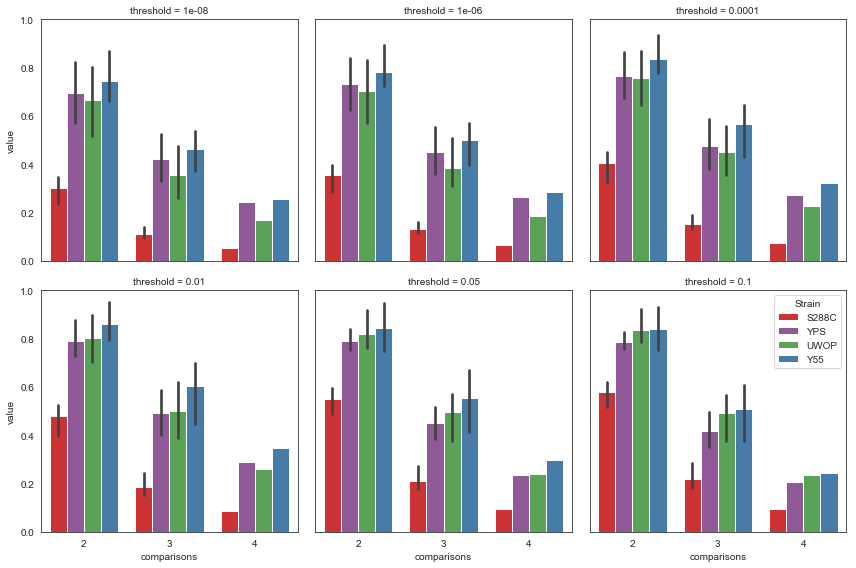

In [12]:
sns.catplot(x='comparisons', y='value',
            hue='strain', col='threshold',
            height=4, aspect=1,
            col_wrap=3,
            kind='bar', data=pp[pp['variable'] == 'shared'],
            hue_order=pp[(pp['variable'] == 'shared') &
                        (pp['comparisons'] == 2)
                       ].groupby('strain')['value'].mean().sort_values().index,
            palette=[cstrains[x] for x in pp[(pp['variable'] == 'shared') &
                                            (pp['comparisons'] == 2)
                                           ].groupby('strain')['value'
                                           ].mean().sort_values().index],
            legend=False)

plt.legend(title='Strain',
           loc='upper right')

# plt.ylabel('Proportion of shared phenotypes')
# plt.xlabel('Number of strains')

sns.despine(top=False,
            right=False)

In [13]:
m = pd.DataFrame([(gn.get(x, x), x, y)
                 for x, y in
                 sorted(set(ds['S288C']),
                        key=lambda x: x[1])],
                 columns=['name', 'gene', 'condition'])

In [14]:
m.to_csv('deviations_rarefaction.tsv',
         sep='\t',
         index=False)

In [15]:
[(gn.get(x, x), y)
 for x, y in sorted(set(ds['S288C']), key=lambda x: x[1])]

[('BRP1', '2,4-Dichlorophenoxyacetic acid (48H)'),
 ('DCW1', '2,4-Dichlorophenoxyacetic acid (48H)'),
 ('RAV1', '2,4-Dichlorophenoxyacetic acid (48H)'),
 ('YNR005C', '2,4-Dichlorophenoxyacetic acid (48H)'),
 ('KRE1', '2,4-Dichlorophenoxyacetic acid (48H)'),
 ('SWM1', '39ºC (48H)'),
 ('ARC18', '39ºC (48H)'),
 ('HSM3', '39ºC (48H)'),
 ('CGR1', '39ºC (48H)'),
 ('CGR1', '39ºC (72H)'),
 ('SWM1', '39ºC (72H)'),
 ('HSM3', '39ºC (72H)'),
 ('DBP3', '5-FU (48H)'),
 ('RRP8', '5-FU (48H)'),
 ('DDC1', '5-FU (48H)'),
 ('SWM1', '6-AU + 39ºC (48H)'),
 ('CWH41', '6-AU + 39ºC (48H)'),
 ('CWH41', '6-AU + 39ºC (72H)'),
 ('SWM1', '6-AU + 39ºC (72H)'),
 ('HAA1', 'Acetic acid (48H)'),
 ('HRK1', 'Acetic acid (48H)'),
 ('SIP3', 'Amphotericin B (48H)'),
 ('SLT2', 'Cadmium chloride (48H)'),
 ('WHI2', 'Cadmium chloride (48H)'),
 ('YCF1', 'Cadmium chloride (48H)'),
 ('CIN8', 'Caffeine 15mM (48H)'),
 ('PPZ1', 'Caffeine 20mM (48H)'),
 ('CIN8', 'Caffeine 20mM (48H)'),
 ('TOR1', 'Caffeine 20mM (48H)'),
 ('CHS1', 'Casp

In [16]:
[(gn.get(x, x), y)
 for x, y in sorted(set(ds['Y55']), key=lambda x: x[1])]

[('BRP1', '2,4-Dichlorophenoxyacetic acid (48H)'),
 ('DCW1', '2,4-Dichlorophenoxyacetic acid (48H)'),
 ('RAV1', '2,4-Dichlorophenoxyacetic acid (48H)'),
 ('YNR005C', '2,4-Dichlorophenoxyacetic acid (48H)'),
 ('KRE1', '2,4-Dichlorophenoxyacetic acid (48H)'),
 ('SWM1', '39ºC (48H)'),
 ('ARC18', '39ºC (48H)'),
 ('HSM3', '39ºC (48H)'),
 ('CGR1', '39ºC (48H)'),
 ('CGR1', '39ºC (72H)'),
 ('SWM1', '39ºC (72H)'),
 ('HSM3', '39ºC (72H)'),
 ('DBP3', '5-FU (48H)'),
 ('RRP8', '5-FU (48H)'),
 ('DDC1', '5-FU (48H)'),
 ('SWM1', '6-AU + 39ºC (48H)'),
 ('CWH41', '6-AU + 39ºC (48H)'),
 ('CWH41', '6-AU + 39ºC (72H)'),
 ('SWM1', '6-AU + 39ºC (72H)'),
 ('HAA1', 'Acetic acid (48H)'),
 ('HRK1', 'Acetic acid (48H)'),
 ('SIP3', 'Amphotericin B (48H)'),
 ('SLT2', 'Cadmium chloride (48H)'),
 ('WHI2', 'Cadmium chloride (48H)'),
 ('YCF1', 'Cadmium chloride (48H)'),
 ('CIN8', 'Caffeine 15mM (48H)'),
 ('PPZ1', 'Caffeine 20mM (48H)'),
 ('CIN8', 'Caffeine 20mM (48H)'),
 ('TOR1', 'Caffeine 20mM (48H)'),
 ('CHS1', 'Casp

In [17]:
[(gn.get(x, x), y)
 for x, y in sorted(set(ds['YPS']), key=lambda x: x[1])]

[('BRP1', '2,4-Dichlorophenoxyacetic acid (48H)'),
 ('DCW1', '2,4-Dichlorophenoxyacetic acid (48H)'),
 ('RAV1', '2,4-Dichlorophenoxyacetic acid (48H)'),
 ('YNR005C', '2,4-Dichlorophenoxyacetic acid (48H)'),
 ('KRE1', '2,4-Dichlorophenoxyacetic acid (48H)'),
 ('SWM1', '39ºC (48H)'),
 ('ARC18', '39ºC (48H)'),
 ('HSM3', '39ºC (48H)'),
 ('CGR1', '39ºC (48H)'),
 ('CGR1', '39ºC (72H)'),
 ('SWM1', '39ºC (72H)'),
 ('HSM3', '39ºC (72H)'),
 ('DBP3', '5-FU (48H)'),
 ('RRP8', '5-FU (48H)'),
 ('DDC1', '5-FU (48H)'),
 ('SWM1', '6-AU + 39ºC (48H)'),
 ('CWH41', '6-AU + 39ºC (48H)'),
 ('CWH41', '6-AU + 39ºC (72H)'),
 ('SWM1', '6-AU + 39ºC (72H)'),
 ('HAA1', 'Acetic acid (48H)'),
 ('HRK1', 'Acetic acid (48H)'),
 ('SIP3', 'Amphotericin B (48H)'),
 ('SLT2', 'Cadmium chloride (48H)'),
 ('WHI2', 'Cadmium chloride (48H)'),
 ('YCF1', 'Cadmium chloride (48H)'),
 ('CIN8', 'Caffeine 15mM (48H)'),
 ('PPZ1', 'Caffeine 20mM (48H)'),
 ('CIN8', 'Caffeine 20mM (48H)'),
 ('TOR1', 'Caffeine 20mM (48H)'),
 ('CHS1', 'Casp

In [18]:
[(gn.get(x, x), y)
 for x, y in sorted(set(ds['UWOP']), key=lambda x: x[1])]

[('BRP1', '2,4-Dichlorophenoxyacetic acid (48H)'),
 ('DCW1', '2,4-Dichlorophenoxyacetic acid (48H)'),
 ('RAV1', '2,4-Dichlorophenoxyacetic acid (48H)'),
 ('YNR005C', '2,4-Dichlorophenoxyacetic acid (48H)'),
 ('KRE1', '2,4-Dichlorophenoxyacetic acid (48H)'),
 ('SWM1', '39ºC (48H)'),
 ('ARC18', '39ºC (48H)'),
 ('HSM3', '39ºC (48H)'),
 ('CGR1', '39ºC (48H)'),
 ('CGR1', '39ºC (72H)'),
 ('SWM1', '39ºC (72H)'),
 ('HSM3', '39ºC (72H)'),
 ('DBP3', '5-FU (48H)'),
 ('RRP8', '5-FU (48H)'),
 ('DDC1', '5-FU (48H)'),
 ('SWM1', '6-AU + 39ºC (48H)'),
 ('CWH41', '6-AU + 39ºC (48H)'),
 ('CWH41', '6-AU + 39ºC (72H)'),
 ('SWM1', '6-AU + 39ºC (72H)'),
 ('HAA1', 'Acetic acid (48H)'),
 ('HRK1', 'Acetic acid (48H)'),
 ('SIP3', 'Amphotericin B (48H)'),
 ('SLT2', 'Cadmium chloride (48H)'),
 ('WHI2', 'Cadmium chloride (48H)'),
 ('YCF1', 'Cadmium chloride (48H)'),
 ('CIN8', 'Caffeine 15mM (48H)'),
 ('PPZ1', 'Caffeine 20mM (48H)'),
 ('CIN8', 'Caffeine 20mM (48H)'),
 ('TOR1', 'Caffeine 20mM (48H)'),
 ('CHS1', 'Casp

In [19]:
(len([(gn.get(x, x), y)
      for x, y in sorted(set(ds['S288C']), key=lambda x: x[1])]), 
 len([(gn.get(x, x), y)
      for x, y in sorted(set(ds['YPS']), key=lambda x: x[1])]),
 len([(gn.get(x, x), y)
      for x, y in sorted(set(ds['Y55']), key=lambda x: x[1])]),
 len([(gn.get(x, x), y)
      for x, y in sorted(set(ds['UWOP']), key=lambda x: x[1])]),)

(73, 73, 73, 73)